In [64]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import numpy
import IPython

%matplotlib inline

In [65]:
pubmed_df = pandas.read_table('data/pubmed.tsv.gz', compression='gzip')

In [115]:
date_df = pandas.read_table('data/dates.tsv', parse_dates=['received', 'accepted', 'published'])
date_df['acceptance_days'] = ((date_df.accepted - date_df.received) / numpy.timedelta64(1, 'D')).astype(int)
date_df['publication_days'] = ((date_df.published - date_df.accepted) / numpy.timedelta64(1, 'D')).astype(int)
date_df['total_days'] = ((date_df.published - date_df.received) / numpy.timedelta64(1, 'D')).astype(int)
date_df['published_year'] = date_df.published.map(toYearFraction)
date_df = date_df.merge(pubmed_df)
len(date_df)

916

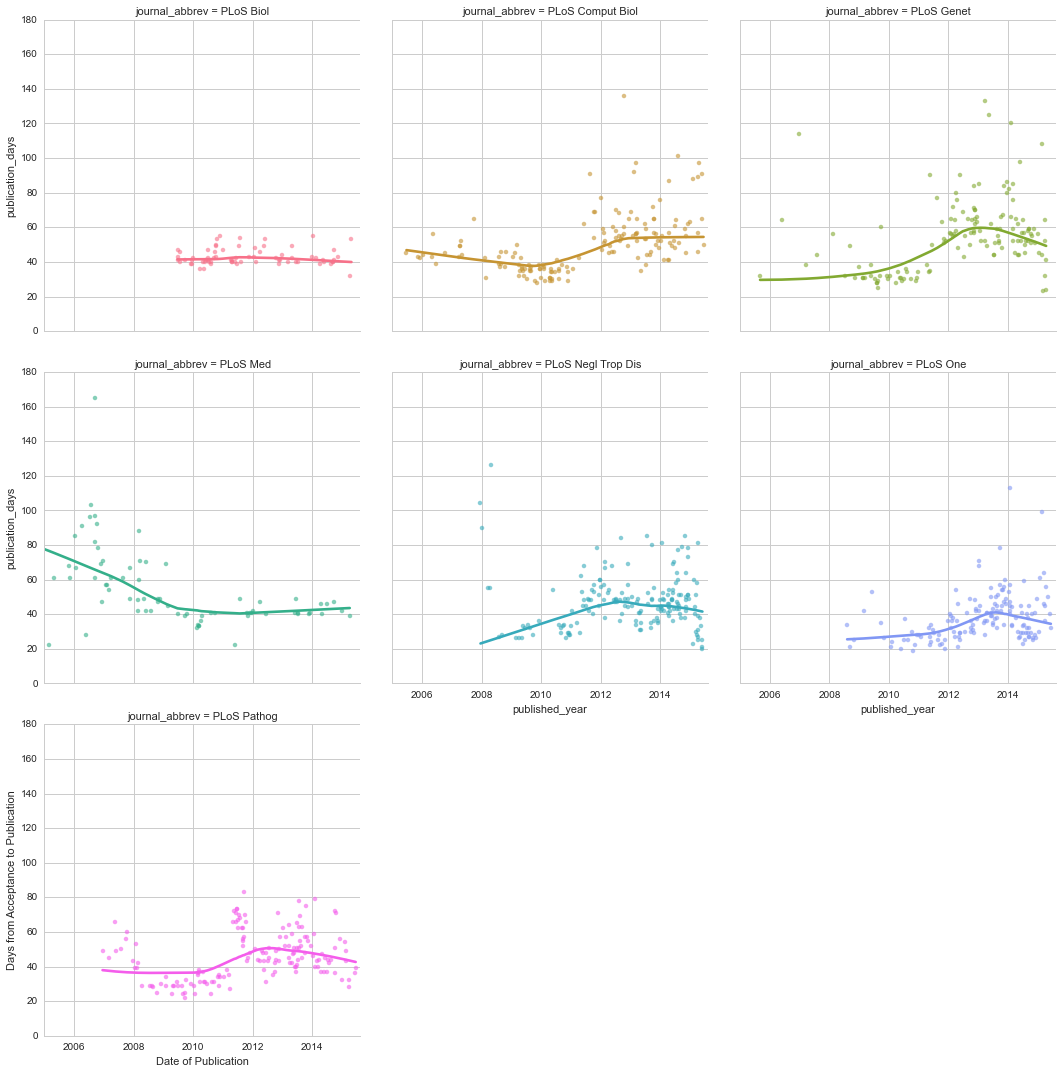

In [116]:
IPython.core.pylabtools.figsize(14, 10)
seaborn.set_style('whitegrid')
grid = seaborn.lmplot(
    x='published_year', y='publication_days',
    data=date_df, robust=False,
                      lowess=True, col='journal_abbrev', hue='journal_abbrev', ci=95, scatter=True, col_wrap=3,
              scatter_kws={'alpha': 0.6},  #markers=['8', '>', '<', '^', 'v', 'D', 's']
);
#grid.set(yscale='log')
plt.xlim((2005, 2015.6))
plt.xlabel('Date of Publication')
plt.ylabel('Days from Acceptance to Publication')
grid.savefig('figure/delays.pdf')
grid.savefig('figure/delays.png', dpi=300)

In [102]:
date_df.head()

,doi,received,accepted,published,acceptance_days,publication_days,total_days,published_year,epub_date,journal,journal_abbrev,pubdate,pubmed_id,pubtype
0,10.1371/journal.ppat.1004931,2014-11-14,2015-05-04,2015-06-09,171,36,207,2015.435502,2015 Jun 9,PLoS pathogens,PLoS Pathog,2015 Jun,26057557,Journal Article
1,10.1371/journal.pntd.0001279,2010-10-18,2011-07-05,2011-08-16,260,42,302,2011.621804,2011 Aug 16,PLoS neglected tropical diseases,PLoS Negl Trop Dis,2011 Aug,21858242,Journal Article
2,10.1371/journal.pbio.1001585,2013-02-26,2013-05-02,2013-06-11,65,40,105,2013.440982,2013 Jun 11,PLoS biology,PLoS Biol,2013,23776409,Journal Article
3,10.1371/journal.pmed.0050101,2007-08-14,2008-03-18,2008-05-27,217,70,287,2008.401526,NaN,PLoS medicine,PLoS Med,2008 May 27,18507497,Journal Article
4,10.1371/journal.pcbi.1003558,2013-07-09,2014-02-19,2014-04-17,225,57,282,2014.290297,2014 Apr 17,PLoS computational biology,PLoS Comput Biol,2014 Apr,24743341,Journal Article


In [71]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction
